# Task 1

$f(x_1, x_2) = (x_1 + x_2^2)^2 = x_1^2 + 2x_1x_2^2 + x_2^4$

$x = (1, 0)$


1. For $p$ to be sedcent direction, the following must be true: $p \cdot \nabla f < 0$

$$
\nabla f = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2} \right)
$$

$$
\nabla f = \left(2x_1 + 2x_2^2, 4x_1x_2 + 4x_2^3\right)
$$

$$
\nabla f(1, 0) = \left(2, 0\right)
$$


$p \cdot \nabla f  = (-1, 1) \cdot (2, 0) = -2 < 0$


2. Find minimizers of $\min\limits_{\alpha > 0} f(x + \alpha p)$

$f(x + \alpha p) = (x_1 + \alpha p_1 + (x_2 + \alpha p_2)^2)^2$

With $x = (1, 0)$, $p = (-1, 1)$:

$f(x + \alpha p) =  (1 - \alpha + \alpha^2)^2$

$\nabla f(x + \alpha p)  = 2(1 - \alpha + \alpha^2)(2\alpha - 1) = 2\alpha^3 - 3\alpha^2 + 3\alpha - 1$

In [3]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
solve(2*x**3 -3*x**2 + 3*x - 1, x)

[1/2, 1/2 - sqrt(3)*I/2, 1/2 + sqrt(3)*I/2]

So, the answer is $\alpha = \frac{1}{2}$

# Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from scipy import optimize

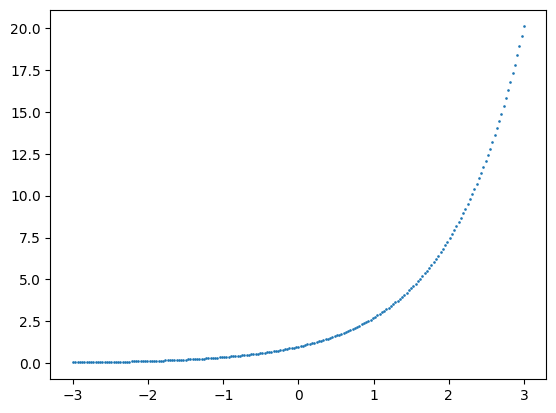

In [2]:
k = 201
X = np.linspace(-3, 3, k)
Y = np.exp(X)
plt.scatter(X, Y, s = 0.8)

In [3]:
def func(x, a):
  return (a[0] + a[1]*x + a[2]*x**2) / (1 + a[3]*x + a[4]*x**2)

Repalce $\max\limits_{i=1..k} |f(x_i) - y_i|$ with vector p-norm: $|f(x) - y|_p = (\sum_{i=1}^{k}|f(x_i) - y_i|^p)^\frac{1}{p}$

In [4]:
def loss(a):
  P = 20
  return jnp.sum((func(X, a) - Y)**P)**(1/P)

In [5]:
def plot_res(a):
  plt.scatter(X, Y, s=0.8, label='Target')
  plt.plot(X, func(X, a), color='darkred', label="Fit")
  plt.legend()

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.23534572767898548
       x: [ 8.086e-01  6.968e-01  1.482e-01 -4.044e-01  4.701e-02]
     nit: 41
     jac: [-9.987e-01  5.122e-01  6.852e-06 -2.058e+00 -5.412e+00]
    nfev: 78
    njev: 78
    nhev: 41
Max diff: 0.16032009382026402


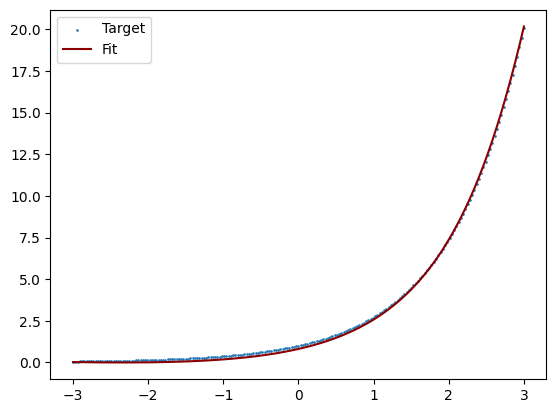

In [6]:
a0 = np.random.normal(size=5)
res = optimize.minimize(loss, a0, jac = jax.grad(loss), hess=jax.hessian(loss), method='Newton-CG')
print(res)
print(f'Max diff: {np.max(func(X, res.x) - Y)}')
plot_res(res.x)

In [8]:
res.x

array([ 0.80860571,  0.69679226,  0.14815466, -0.40442184,  0.0470066 ])

So, optimal values are:
$$
a_0 = 0.80860571
$$

$$
a_1 = 0.69679226
$$

$$
a_2 = 0.14815466
$$

$$
b_1 = -0.40442184
$$

$$
b_2 = 0.0470066
$$

# Task 3

Lets solve the following optimization problem:

$$
\min\limits_{dr} \sum_{ijk}(\Theta_{ijk} - arccos\frac{(r_i + dr_{i} - r_j - dr_{j})\dot(r_k + dr_{k}- r_j - dr_{j})}{|r_i + dr_{i} - r_j - dr_{j}| |r_k + dr_{k}- r_j - dr_{j}|})^2
$$

, where $dr_i = (x_i, y_i)$ is correction for the initial estimate $r_i$

In [19]:
import pandas as pd

def read_data(f_path):
  dr = pd.read_hdf(f_path, "dr", mode="r+")
  measurements = pd.read_hdf(f_path, "measurements", mode="r+")
  r = pd.read_hdf(f_path, "r", mode="r+")
  return dr, r, measurements

dr, r, measurements = read_data('./localization_data_1.hdf')

In [20]:
def solve(dr, r, measurements):
  points = r.to_numpy()
  measures = measurements.to_numpy()

  N = len(points)
  # Each point has 2 axis
  N_vars = 2 * N
  N_thetas = len(measures)
  points_linear = np.array(points).reshape(N_vars)

  # Indication matrixes for tree vectors active at each measurement
  I_1 = np.zeros((N_thetas, 2, N_vars))
  I_2 = np.zeros((N_thetas, 2, N_vars))
  I_3 = np.zeros((N_thetas, 2, N_vars))

  i = 0
  thetas =[]
  for id_1, id_2, id_3, theta in measures:
      thetas.append(theta)
      I_1[i][0][2 * int(id_1 - 1)] = 1
      I_1[i][1][2 * int(id_1 - 1) + 1] = 1

      I_2[i][0][2 * int(id_2 - 1)] = 1
      I_2[i][1][2 * int(id_2 - 1) + 1] = 1

      I_3[i][0][2 * int(id_3 - 1)] = 1
      I_3[i][1][2 * int(id_3 - 1) + 1] = 1

      i += 1

  thetas = np.array(thetas)

  def func(idx_1, idx_2, idx_3, dr):
    r1 = idx_1 @ points_linear + idx_1 @ dr
    r2 = idx_2 @ points_linear + idx_2 @ dr
    r3 = idx_3 @ points_linear + idx_3 @ dr
    return jnp.arccos((r3 - r1).dot(r2 - r1) / (jnp.sqrt((r3 - r1).dot(r3 - r1)) * jnp.sqrt((r2 - r1).dot(r2 - r1))))

  def loss(dr):
    res = 0
    for i in range(I_1.shape[0]):
      res += (func(I_1[i], I_2[i], I_3[i], dr) - thetas[i])**2
    return res

  dr_opt = np.random.normal(size=N_vars)
  return optimize.minimize(loss, dr_opt, jac = jax.grad(loss), hess=jax.hessian(loss), method='Newton-CG')


In [22]:
def print_res(res, dr, r, measurements):
  measures = measurements.to_numpy()
  drs_1 = res.x.reshape(len(res.x) // 2, 2)
  print(f'Got drs: {drs_1}\nExpected: {dr.to_numpy()}')

  points = r.to_numpy()
  for id_1, id_2, id_3, theta in measures:
    r1 = points[int(id_1 - 1)] + drs_1[int(id_1 - 1)]
    r2 = points[int(id_2 - 1)] + drs_1[int(id_2 - 1)]
    r3 = points[int(id_3 - 1)] + drs_1[int(id_3 - 1)]

    sol = jnp.arccos((r3 - r1).dot(r2 - r1) / (jnp.sqrt((r3 - r1).dot(r3 - r1)) * jnp.sqrt((r2 - r1).dot(r2 - r1))))
    print(f'\nGot angle: {sol}, expected: {theta}')

res = solve(dr, r, measurements)
print_res(res, dr, r, measurements)

Got drs: [[-0.87734302 -0.24694335]
 [-0.19982517  0.06240815]
 [ 0.90629073 -0.41392058]]
Expected: [[-0.0392699  0.       ]
 [ 0.0392699 -0.0392699]
 [ 0.         0.0392699]]

Got angle: 0.7068580000000022, expected: 0.706858


Even though $dr$ do not match, angle is calculated correctly with the resulting dr.

Lets change task to minimisation of the L2 norm of resuting dr, with contraints on equation.

$$
\min\limits_{dr} ||dr||_{2}
$$

$$
, s.t. \Theta_{ijk} - arccos\frac{(r_i + dr_{i} - r_j - dr_{j})\dot(r_k + dr_{k}- r_j - dr_{j})}{|r_i + dr_{i} - r_j - dr_{j}| |r_k + dr_{k}- r_j - dr_{j}|} = 0
$$

In [23]:
from scipy.optimize import NonlinearConstraint

def solve_min_norm(dr, r, measurements):
  points = r.to_numpy()
  measures = measurements.to_numpy()

  N = len(points)
  # Each point has 2 axis
  N_vars = 2 * N
  N_thetas = len(measures)
  points_linear = np.array(points).reshape(N_vars)

  # Indication matrixes for tree vectors active at each measurement
  I_1 = np.zeros((N_thetas, 2, N_vars))
  I_2 = np.zeros((N_thetas, 2, N_vars))
  I_3 = np.zeros((N_thetas, 2, N_vars))

  i = 0
  thetas =[]
  for id_1, id_2, id_3, theta in measures:
      thetas.append(theta)
      I_1[i][0][2 * int(id_1 - 1)] = 1
      I_1[i][1][2 * int(id_1 - 1) + 1] = 1

      I_2[i][0][2 * int(id_2 - 1)] = 1
      I_2[i][1][2 * int(id_2 - 1) + 1] = 1

      I_3[i][0][2 * int(id_3 - 1)] = 1
      I_3[i][1][2 * int(id_3 - 1) + 1] = 1

      i += 1

  thetas = np.array(thetas)

  def func(idx_1, idx_2, idx_3, dr):
    r1 = idx_1 @ points_linear + idx_1 @ dr
    r2 = idx_2 @ points_linear + idx_2 @ dr
    r3 = idx_3 @ points_linear + idx_3 @ dr
    return jnp.arccos((r3 - r1).dot(r2 - r1) / (jnp.sqrt((r3 - r1).dot(r3 - r1)) * jnp.sqrt((r2 - r1).dot(r2 - r1))))

  def loss(dr):
   return dr @ dr

  def constraint_eq(dr, i):
    res = (func(I_1[i], I_2[i], I_3[i], dr) - thetas[i])
    return res

  def create_constraints(i):
    return NonlinearConstraint(lambda x: [constraint_eq(x, i)], [0], [0], jac=lambda x: [jax.grad(constraint_eq)(x, i)])

  constraints = [create_constraints(i) for i in range(N_thetas)]

  x0 = np.random.normal(size=N_vars)
  return optimize.minimize(loss,
                            x0=x0,
                            jac = jax.grad(loss),
                            hess=jax.hessian(loss),
                            method='trust-constr',
                            tol=1e-9,
                            constraints=constraints)

res_min_norm = solve_min_norm(dr, r, measurements)
print_res(res_min_norm, dr, r, measurements)

Got drs: [[-0.03752991  0.00243625]
 [ 0.03829577 -0.04316824]
 [-0.00076585  0.040732  ]]
Expected: [[-0.0392699  0.       ]
 [ 0.0392699 -0.0392699]
 [ 0.         0.0392699]]

Got angle: 0.706858, expected: 0.706858


We got almost exact answer with small dr, which are close to real solution.

In [24]:
# Lets also check on the second dataset

dr, r, measurements = read_data('./localization_data_2.hdf')

res_min_norm_2 = solve_min_norm(dr, r, measurements)
print_res(res_min_norm_2, dr, r, measurements)

Got drs: [[-0.02742501 -0.00052617]
 [ 0.00963888 -0.10606422]
 [-0.01564825  0.08242307]
 [-0.10136683 -0.04365911]
 [ 0.06698944  0.03861954]
 [ 0.06781178  0.02920689]]
Expected: [[-0.0124687   0.00019365]
 [ 0.0131732  -0.104997  ]
 [-0.0193151   0.0708246 ]
 [-0.123992   -0.0060532 ]
 [ 0.0700385   0.0109086 ]
 [ 0.0725637   0.0291229 ]]

Got angle: 1.5708000000000002, expected: 1.5708

Got angle: 1.5708, expected: 1.5708

Got angle: 0.5235989999999996, expected: 0.523599

Got angle: 1.0472, expected: 1.0472


On both datasets optimization seem to work fine.

# Task 4

Let $U$ be the matrix, each column of which, $u_i$, represents eigenvectors, corresponding to the smallest eigenvalues.

In our case matrix $U \in R^{dx2}$ with column $u_0$ corresponding to the smallest eigenvalue and $u_1$ - to the second smallest eigenvalue.

Then eigenvalues will be the diagonal elements of matrix:
$$
U^T A U
$$

, which mean we can minimize the trace of this matrix with the following constrains:

1. Norm of eigenvector is one: $||u_{i}||_2 = 1$
2. Eigenvectors are orthogonal: $(u_0 · u_1) = 0$
3. Eigenvalue corresponding to $u_0$ < eigenvalue corresponding to $u_1$


$$
\min_{u_0, u_1} trace(U^T A U)
$$

s.t.
$$
||u_0||_2 = 1
$$

$$
||u_1||_2 = 1
$$

$$
(u_0 ⋅ u_1) = 0
$$

$$
u_0^T A u_0 - u_1^T A u_1 < 0
$$

In [25]:
N = 10

def create_symmetric_matrix(n):
  b = np.random.normal(size=(n,n))
  b_symm = (b + b.T) / 2
  assert((b_symm == b_symm.T).all())
  return b_symm

# Create more matrix to test on it
A = create_symmetric_matrix(N)
print(A)


[[ 0.58862153  1.10431342  0.47248538 -0.07674636 -0.28505546 -0.40916306
  -0.28261235 -0.40170085 -0.73998898  1.04518022]
 [ 1.10431342 -0.13108866 -0.03420665  0.0813005  -1.1696758  -0.01827358
   0.3668879  -0.61373679  0.51049257  0.8194044 ]
 [ 0.47248538 -0.03420665  0.44409604  0.48426867  0.86096348  0.1576326
   0.33202947  0.77527907 -0.53355775  0.51429503]
 [-0.07674636  0.0813005   0.48426867  0.05438194  0.92550804  0.80065858
  -0.26627634  0.02388564  0.76452864 -0.58295329]
 [-0.28505546 -1.1696758   0.86096348  0.92550804  1.13180329  1.0665866
   1.05371598  0.77116907  1.37450685 -1.57325273]
 [-0.40916306 -0.01827358  0.1576326   0.80065858  1.0665866   0.34464278
  -0.50938259  0.63572395 -0.88338601  0.47178961]
 [-0.28261235  0.3668879   0.33202947 -0.26627634  1.05371598 -0.50938259
   1.30327222  0.23392317  0.40804877 -0.2350667 ]
 [-0.40170085 -0.61373679  0.77527907  0.02388564  0.77116907  0.63572395
   0.23392317  0.22216269  0.79832746 -0.53204037]
 [

In [28]:
# Check eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A)

# sort by min eigenvalue
idx = list(reversed(eigenvalues.argsort()[::-1]))
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

lambda_1 = eigenvalues[0]
lambda_2 = eigenvalues[1]

# print the first two minimal eigenvectors
print(f'Minimal eigenvalues:\n{eigenvalues[:2]}')
print(f'\nMinimal eigenvectors: ')
print(eigenvectors[:, :2])

Minimal eigenvalues:
[-3.09502853 -1.4662386 ]

Minimal eigenvectors: 
[[-0.24285223 -0.26739847]
 [ 0.30113093  0.53260765]
 [-0.23499155  0.31304316]
 [ 0.15807031 -0.5319343 ]
 [ 0.45124279  0.25959165]
 [-0.4170442   0.11051393]
 [-0.12147403 -0.27720228]
 [ 0.22824189 -0.24084797]
 [-0.44893296  0.10983024]
 [ 0.35241835 -0.1932986 ]]


In [29]:
from scipy.optimize import NonlinearConstraint

def loss_f(u):
  U = u.reshape(N, 2)
  val = jnp.matmul(jnp.matmul(U.T, A), U)
  return val.trace()

def constraint_norm_first(u):
  U = u.reshape(N, 2)
  return U[:, 0] @ U[:, 0] - 1

def constraint_norm_second(u):
  U = u.reshape(N, 2)
  return U[:, 1] @ U[:, 1] - 1

def constraint_vectors_orthogonal(u):
  U = u.reshape(N, 2)
  return U[:, 0] @ U[:, 1]

def constraint_eigenvalues_order(u):
  U = u.reshape(N, 2)
  v1 = U[:, 0] @ A @ U[:, 0]
  v2 = U[:, 1] @ A @ U[:, 1]
  return v2 - v1

cstr_1 = NonlinearConstraint(lambda x: [constraint_norm_first(x)], [-1e-10], [1e-10], jac=lambda x: [jax.grad(constraint_norm_first)(x)])
cstr_2 = NonlinearConstraint(lambda x: [constraint_norm_second(x)], [-1e-10], [1e-10], jac=lambda x: [jax.grad(constraint_norm_second)(x)])
cstr_3 = NonlinearConstraint(lambda x: [constraint_vectors_orthogonal(x)], [-1e-10], [1e-10], jac=lambda x: [jax.grad(constraint_vectors_orthogonal)(x)])
cstr_4 = NonlinearConstraint(lambda x: [constraint_eigenvalues_order(x)], [-1e-10], [1e10], jac=lambda x: [jax.grad(constraint_eigenvalues_order)(x)])

x0 = np.random.normal(size=2*N)
x0 = x0 / (x0 @ x0)**0.5
result = optimize.minimize(loss_f,
                           x0=x0,
                           jac = jax.grad(loss_f),
                           hess=jax.hessian(loss_f),
                           method='trust-constr',
                           tol=1e-5,
                           constraints=[cstr_1, cstr_2, cstr_3, cstr_4])
result.x

array([ 0.24318924,  0.26709172, -0.30180324, -0.53222714,  0.23459634,
       -0.3133395 , -0.15739855,  0.5321334 , -0.45156948, -0.25902188,
        0.41690452, -0.11104025,  0.12182403,  0.27704874, -0.22793741,
        0.24113585,  0.44879419, -0.11039679, -0.35217454,  0.19374327])

In [30]:
print(eigenvectors[:, :2])

[[-0.24285223 -0.26739847]
 [ 0.30113093  0.53260765]
 [-0.23499155  0.31304316]
 [ 0.15807031 -0.5319343 ]
 [ 0.45124279  0.25959165]
 [-0.4170442   0.11051393]
 [-0.12147403 -0.27720228]
 [ 0.22824189 -0.24084797]
 [-0.44893296  0.10983024]
 [ 0.35241835 -0.1932986 ]]


In [31]:
print(result.x.reshape(N, 2))

[[ 0.24318924  0.26709172]
 [-0.30180324 -0.53222714]
 [ 0.23459634 -0.3133395 ]
 [-0.15739855  0.5321334 ]
 [-0.45156948 -0.25902188]
 [ 0.41690452 -0.11104025]
 [ 0.12182403  0.27704874]
 [-0.22793741  0.24113585]
 [ 0.44879419 -0.11039679]
 [-0.35217454  0.19374327]]


In [32]:
# Check results

u1 = result.x.reshape(N, 2)[:, 0]
u2 = result.x.reshape(N, 2)[:, 1]

print(f'Calculated eigenvalue - actual eigenvalue')
print(f'1. {u1 @ A @ u1} ~ {lambda_1}')
print(f'2, {u2 @ A @ u2} ~ {lambda_2}')

Calculated eigenvalue - actual eigenvalue
1. -3.0950259304178283 ~ -3.095028525321461
2, -1.4662411922835248 ~ -1.4662385973671472


Eigenvalues, calculated by minimization, are close to actual ones.

# Task 5

In [33]:
import os
import pickle
import pandas as pd


In [68]:
sensor_data = pd.read_pickle(r'data_sensors.pickle')
sensor_data

{0: (6, 3, array([-0.34491957, -0.93863225])),
 1: (7, 4, array([ 0.30168622, -0.95340727])),
 2: (6, 9, array([-0.99899616, -0.04479592])),
 3: (2, 6, array([0.6019477 , 0.79853551])),
 4: (7, 4, array([ 0.35073944, -0.93647309])),
 5: (3, 7, array([0.0343622 , 0.99940945])),
 6: (7, 2, array([-0.3349917 , -0.94222108])),
 7: (5, 4, array([-0.30845617, -0.95123856])),
 8: (1, 7, array([0.59771565, 0.80170818])),
 9: (5, 1, array([-0.96628289, -0.25748279])),
 10: (4, 0, array([-0.94530973,  0.32617406])),
 11: (9, 5, array([ 0.95864174, -0.28461554])),
 12: (8, 0, array([-0.63402992, -0.77330852])),
 13: (9, 2, array([ 0.22505481, -0.9743461 ])),
 14: (6, 3, array([-0.33094948, -0.94364847])),
 15: (8, 2, array([ 0.09684405, -0.99529957])),
 16: (4, 2, array([-0.9192423 , -0.39369226])),
 17: (6, 4, array([-0.12174657, -0.99256122])),
 18: (8, 6, array([ 0.96608604, -0.25822038])),
 19: (1, 3, array([ 0.96413638, -0.2654073 ])),
 20: (8, 1, array([-0.40742147, -0.91324025])),
 21: (9,

In [69]:
N = max([max(item[0], item[1]) for _, item in sensor_data.items()]) + 1
print(f'Number of sensors: {N}')

Number of sensors: 10


In [70]:
n = dict()
for _, item in sensor_data.items():
    i = item[0] #min(item[0], item[1])
    j = item[1] #max(item[0], item[1])
    if (i, j) in n:
      print(f'Duplicate value {item[2]} for [{i}, {j}] - existing {n[(i, j)]}')
      continue
    n[(i, j)] = item[2]

Duplicate value [ 0.35073944 -0.93647309] for [7, 4] - existing [ 0.30168622 -0.95340727]
Duplicate value [-0.33094948 -0.94364847] for [6, 3] - existing [-0.34491957 -0.93863225]
Duplicate value [ 0.96640663 -0.25701795] for [1, 3] - existing [ 0.96413638 -0.2654073 ]
Duplicate value [-0.00132016  0.99999913] for [1, 9] - existing [-0.15861812  0.98734001]
Duplicate value [0.04547498 0.99896548] for [3, 7] - existing [0.0343622  0.99940945]
Duplicate value [ 0.31174011 -0.95016741] for [7, 4] - existing [ 0.30168622 -0.95340727]


In [71]:
n.keys()

dict_keys([(6, 3), (7, 4), (6, 9), (2, 6), (3, 7), (7, 2), (5, 4), (1, 7), (5, 1), (4, 0), (9, 5), (8, 0), (9, 2), (8, 2), (4, 2), (6, 4), (8, 6), (1, 3), (8, 1), (9, 8), (9, 4), (6, 7), (2, 0), (3, 1), (7, 3), (1, 5), (5, 9), (3, 5), (1, 9), (6, 8), (1, 4), (7, 9)])

There are duplicate elements in dataset, ignore them

In [90]:
import itertools
from scipy.optimize import NonlinearConstraint

comb_list = n.keys() #list(itertools.combinations(range(N), r=2))

def x_idx(i): return 2*i
def y_idx(i): return 2*i + 1

def func(x, i, j):
  #assert (i < j)
  #if (i, j) not in n:
  #  return 0
  x_reshaped = x.reshape(N, 2)
  dir = (x_reshaped[i] - x_reshaped[j])
  return dir - n[i, j] * jnp.dot(dir, n[i, j])

def loss(x):
  summ = 0
  for i, j in comb_list:
    summ += jnp.linalg.norm(func(x, i, j))
  return summ

def constraint_dist(x, i, j):
  x = x.reshape(N, 2)
  return jnp.linalg.norm(x[i] - x[j])

# lets demand that vectors differ
def create_constraint(i, j):
  return NonlinearConstraint(lambda x: [constraint_dist(x, i, j)], [1e-2], [1e10], jac=lambda x: [jax.grad(constraint_dist)(x, i, j)])

constraints = [create_constraint(i, j) for i, j in comb_list]

x0 = np.random.normal(size=2*N)
x0 = x0 / (x0 @ x0)**0.5

res = optimize.minimize(loss,
                        x0,
                        jac = jax.grad(loss),
                        hess=jax.hessian(loss),
                        method='SLSQP',
                        constraints=constraints)
res

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method SLSQP does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17624290136917856
       x: [ 1.059e-01  2.042e-02 ...  1.016e-01  4.070e-02]
     nit: 45
     jac: [-3.648e-01 -2.163e+00 ... -2.128e+00  3.235e+00]
    nfev: 150
    njev: 45

In [91]:
# check result
loss(res.x)

Array(0.1762429, dtype=float64)

In [92]:
# Result positions:
res.x.reshape(N, 2)

array([[0.10591931, 0.02041732],
       [0.12072862, 0.04137217],
       [0.11127054, 0.03812347],
       [0.10508247, 0.04597909],
       [0.11223555, 0.02817012],
       [0.11127052, 0.03812346],
       [0.10257323, 0.03074683],
       [0.1052335 , 0.02103045],
       [0.11223851, 0.02816767],
       [0.10160821, 0.04070017]])

# Task 7

**1. Show that function $f(x, y) = \frac{x^2}{y}$ defined on $y > 0$ is convex.**

For f to be convex, the following must be true: $\forall u,  u^T \nabla ^2 f u >= 0$

$$
\nabla f  =
\left( \begin{matrix}
\frac{2x}{y} \\ -\frac{x^2}{y^2}
\end{matrix} \right)
$$

$$
\nabla^2 f  =
\left( \begin{matrix}
\frac{2}{y} & -\frac{2x}{y^2}\\ -\frac{2x}{y^2} & \frac{2x^2}{y^3}
\end{matrix} \right)
$$

$$
u^T \nabla^2 f u =
\left( \begin{matrix}
u_1 & u_2
\end{matrix} \right) \cdot \left( \begin{matrix}
\frac{2}{y} & -\frac{2x}{y^2}\\ -\frac{2x}{y^2} & \frac{2x^2}{y^3}
\end{matrix} \right) \cdot \left( \begin{matrix}
u_1 \\ u_2
\end{matrix} \right)
$$

$$
= \frac{2u_{1}^2}{y} - \frac{2x u_{2} u_{1}}{y^2} - \frac{2 x u_{1}u_2}{y^2} + \frac{2u_2^2x^2}{y^3}
$$


$$
= \frac{2 u_{1}^2 y^2 - 4x u_{1} u_{2} y + 2 u_{2}^2 x^2 }{y3}
$$

$$
= \frac{2(u_{1}y - u_{2}x)^2}{y3} > 0 , proven
$$

**2. Show that geometric mean $f(x) = (\prod_{k=1}^n x_k)^\frac{1}{n}$ defined on $R_{++}$ is concave.**

To prove that we can show that $f(x) = - (\prod_{k=1}^n x_k)^\frac{1}{n}$ is convex.

$$
\frac{\partial f}{\partial x_i}  = - (\prod_{k=1}^n x_k)^\frac{1}{n} \cdot \frac{1}{x_i^\frac{1}{n}} \cdot \frac{1}{n} \cdot x_i^\frac{1-n}{n} = - (\prod_{k=1}^n x_k)^\frac{1}{n} \cdot \frac{1}{n} \cdot \frac{1}{x_i}
$$

$$
\frac{\partial^2 f}{\partial x_i^2} = (\prod_{k=1}^n x_k)^\frac{1}{n} \cdot \frac{1}{n^2} \cdot \frac{n - 1}{x_i^2}
$$

$$
\frac{\partial^2 f}{\partial x_i \partial x_j} = (\prod_{k=1}^n x_k)^\frac{1}{n} \cdot \frac{1}{n^2} \cdot \frac{-1}{x_i \cdot x_j}
$$

$$
\nabla^2 f = (\prod_{k=1}^n x_k)^\frac{1}{n} \cdot \frac{1}{n^2} \cdot
\left( \begin{matrix}
\frac{n-1}{x_1^2} & \frac{-1}{x_1 x_2} & \frac{-1}{x_1 x_3} ... \\
\frac{-1}{x_2 x_1} & \frac{n-1}{x_2^2} & \frac{-1}{x_2 x_3} ... \\
... & ...& ... & ...
\end{matrix} \right)
$$

Since $f$ is defined on $R_{++}$, than $(\prod_{k=1}^n x_k)^\frac{1}{n} \cdot \frac{1}{n^2} $ is just some positive constant, which we can ignore.

$$
\nabla^2 f =
\left( \begin{matrix}
\frac{n}{x_1^2} & 0 & 0 ... \\
0 & \frac{n}{x_2^2} & 0 ... \\
... & ...& ... & ...
\end{matrix} \right) -
\left( \begin{matrix}
\frac{1}{x_1^2} & \frac{1}{x_1 x_2} & \frac{1}{x_1 x_3} ... \\
\frac{1}{x_2 x_1} & \frac{1}{x_2^2} & \frac{1}{x_2 x_3} ... \\
... & ...& ... & ...
\end{matrix} \right)
$$

$$
\xi = (\frac{1}{x_1^2}, \frac{1}{x_2^2},...)
$$

$$
\gamma = (\frac{1}{x_1}, \frac{1}{x_2},...)
$$

$$
\nabla^2 f = n \cdot diag(\xi) - \gamma^T \cdot \gamma
$$

Lets prove that $y^T \nabla^2f y > 0 $

$$
y^T \nabla^2 f y =  y^T \cdot (n \cdot diag(\xi) - \gamma^T \cdot \gamma) \cdot y
$$

$$
 = y^T n \cdot diag(\xi) \cdot y - y^T \cdot \gamma^T \cdot \gamma \cdot y
$$

$$
= n \cdot \sum_i^n(\frac{y_i}{x_i})^2 - (\gamma \cdot y)^T (\gamma \cdot y)
$$

$$
= n \cdot \sum_i^n(\frac{y_i}{x_i})^2 - \sum_i^n(\frac{y_i}{x_i})^2
$$

$$
= (n - 1) \cdot \sum_i^n(\frac{y_i}{x_i})^2 > 0, proven
$$

**3. Show than the function $f(x) = \ln \sum_{k=1}^n \exp(x_k)$ defined on $R^n$ is convex.**

$$\frac{\partial^2 f}{\partial x_i^2} = \frac{\partial}{\partial x_i}\left(\frac{1}{\sum_{k=1}^n e^{x_k}} e^{x_i}\right)$$

$$\frac{\partial^2 f}{\partial x_i^2} = \frac{1}{\sum_{k=1}^n e^{x_k}} e^{x_i} - \frac{1} {(\sum_{k=1}^n e^{x_k})^2} e^{2x_i} $$

$$\frac{\partial^2 f}{\partial x_i x_j} = \frac{\partial}{\partial x_j}\left(\frac{1}{\sum_{k=1}^n e^{x_k}} e^{x_i}\right)$$

$$\frac{\partial^2 f}{\partial x_i x_j} =  - \frac{1} {(\sum_{k=1}^n e^{x_k})^2} e^{x_i+x_j} $$

$$\xi = \left( e^{x_1}, e^{x_2}, ... \right)$$

$$\nabla^2 f = \frac{1}{\vec 1 \cdot \xi} \text{diag} (\xi) - \frac{1}{\left(\vec 1 \cdot \xi\right)^2} \xi\xi^T$$

$\forall v: v^T \nabla^2 f v \ge 0$

$$
\frac{\sum \xi_i v_i^2}{\sum \xi_i} - \frac{\sum (v_i \xi_i)^2}{\left(\sum \xi_i\right)^2} = \frac{\sum \xi_i \cdot \sum \xi_i v_i^2 - \sum (v_i \xi_i)^2}{\left(\sum \xi_i\right)^2} \ge 0, proven
$$

# Task 10

In [93]:
from numpy import load

data = load('data_fit.npz')
X = data['x']
Y = data['y']

N = len(X)

In [94]:
def func(x, vars):
  return vars[0]*x**2 + vars[1]*x + vars[2]

def cost_1(vars):
  return sum((func(X, vars) - Y)**2)

def cost_2(vars):
  return sum(abs(func(X, vars) - Y))

In [95]:
import cvxpy as cp

# 1. Solve with first cost fucntion

# 1.1 using cvxpy
vars_1 = cp.Variable(3)
cost_1 = sum((func(X, vars_1) - Y)**2)

obj_1 = cp.Minimize(cost_1)
prob_1 = cp.Problem(obj_1, None)
res_cvxpy = prob_1.solve()

print(f'Result = {res_cvxpy}')
print(f'Values: {vars_1.value}')
print(f'Diff: {np.linalg.norm(func(X, vars_1.value) - Y)}')

Result = 8651.962373485067
Values: [1.11782318 0.92097453 7.21154154]
Diff: 93.01592537563162


In [97]:
cost_1

Expression(CONVEX, NONNEGATIVE, ())

In [98]:
# 1.2. using linalgsolve
A = np.ones((N, 3))
for i, x in enumerate(X):
  A[i][0] = x**2
  A[i][1] = x
  # leave A[i][2] be equal to 1

res_lstsq = np.linalg.lstsq(A, Y, rcond=None)
print(f'Result = {res_lstsq[1]}')
print(f'Values: {res_lstsq[0]}')
print(f'Diff: {np.linalg.norm(A @ res_lstsq[0] - Y)}')

Result = [8651.96237349]
Values: [1.11782318 0.92097453 7.21154154]
Diff: 93.01592537563162


Results are almost identical, ok.

In [100]:
# 2. Solve with second cost fucntion

vars_2 = cp.Variable(3)
cost_2 = sum(cp.abs(func(X, vars_2) - Y))

obj_2 = cp.Minimize(cost_2)
prob_2 = cp.Problem(obj_2, None)
res_cvxpy = prob_2.solve()

print(f'Result = {res_cvxpy}')
print(f'Values: {vars_2.value}')
print(f'Diff: {np.linalg.norm(func(X, vars_2.value) - Y)}')

Result = 274.05038589777644
Values: [0.99559659 2.11117662 1.95467955]
Diff: 103.10633139617677


In [101]:
cost_2

Expression(CONVEX, NONNEGATIVE, ())

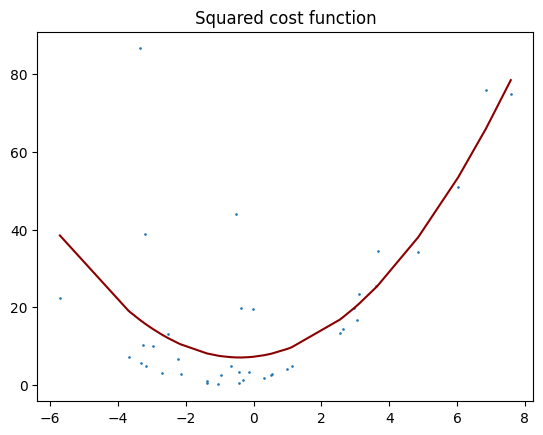

In [102]:
# Plot data

def print_plot(X, Y, fit, title):
  plt.scatter(X, Y, s=0.8, label='Target')
  plt.plot(X, fit, color='darkred', label="Fit")
  plt.title(title)

print_plot(X, Y, list(func(X, vars_1.value)), 'Squared cost function')

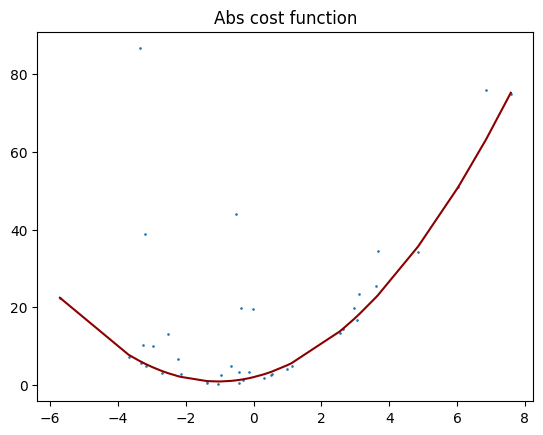

In [103]:
print_plot(X, Y, list(func(X, vars_2.value)), 'Abs cost function')

In general visually plot with squared cost function seems to fit data better. Plot with abs cost function goes through certain points at the bottom, while being too far from top points.

The reson for it might be that squared function better punishes big distances, taking the square of them.


# Task 11

In [104]:
from numpy import load

data = load('data_linprog.npz')
A = data['X']
y = data['y']

n = len(A)
k = len(A[0])
print(f'n = {n}, k = {k}')

n = 10, k = 20


$$\min\limits_{x}  \sum_{i=1}^k|x_i|$$
$$ s.t. Ax = y $$



Lets intriduce variable $t_i >= |x_i|$ => $t_i >= x_i, -t_i <= x_i$

Then optimization problem can be stated as following:

$$
\min \limits_{t} \sum t_i
$$

$$
s.t. Ax = y
$$

$$
x_i <= t_i
$$

$$
x_i >= -t_i
$$

To solve it with scipy.optimize.linprog we have to reformulate the problem:

$$
\bar x = (x_1, x_2, ..., x_k, t_1, t_2, ..., t_k)
$$

$$
c = (0_1, 0_2, ..., 0_k, 1_1, 1_2, ..., 1_k)
$$

$$
A_{eq} = \left( \begin{matrix}
A & 0
\end{matrix} \right), A_{eq} \in R^{n, 2k}
$$

$$
A_{ub} =  \left( \begin{matrix}
I^{kxk}, -I^{kxk} \\
-I^{kxk}, -I^{kxk}
\end{matrix} \right) , A_{ub} \in R^{2k, 2k}
$$

$$
b_{ub} = (0_1, 0_2, ..., 0_{2k})
$$

Then the final problem is:

$$
\min \limits_{\bar x} c \bar x^T
$$

$$
s.t. A_{ub}\bar x^T <= b_{ub}
$$

$$
A_{ex}\bar x^T = y
$$

$$
\bar x > (-\inf, -\inf, ...., 0, 0, ...0)
$$

In [105]:
from scipy.optimize import linprog

c = [0]*k + [1]*k
A_eq = np.concatenate([A, np.zeros((n, k))], axis=1)

diag = np.diag(np.full(k,1))
upper_part = np.concatenate([diag, -diag], axis=1)
lower_part = np.concatenate([-diag, -diag], axis=1)
A_ub = np.concatenate([upper_part, lower_part], axis=0)
b_ub = np.zeros(2*k)

x_bounds = [(None, None)]*k
t_bounds = [(0, None)]*k
bounds = x_bounds + t_bounds

In [106]:
res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=y, bounds=bounds)
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 9.634439501271336
              x: [-1.602e+00 -4.835e-13 ...  1.163e+00  2.855e+00]
            nit: 34
          lower:  residual: [       inf        inf ...  1.163e+00
                              2.855e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00]
                 marginals: [ 3.152e-01  5.945e-01 -4.395e-01  2.630e-02
                              4.893e-01  5.334e-01  7.701

In [107]:
# Check correctness

x = res.x[:k]
A @ x - y

array([-4.44089210e-16, -1.77635684e-15, -3.55271368e-15,  4.44089210e-16,
       -4.44089210e-16,  8.88178420e-16,  2.66453526e-15,  1.33226763e-15,
        3.33066907e-16,  4.44089210e-16])

Errors are close to zero.

In [108]:
np.linalg.norm(x, ord=1)

9.634439501273908

# Task 12

In [109]:
from numpy import load

data = load('data_regr.npz')
X = data['X']
y = data['y']

n = len(X)
k = len(X[0])
print(f'n = {n}, k = {k}')

n = 200, k = 100


In [110]:
import cvxpy as cp

def solve(lambd, ord):
  a = cp.Variable(k)
  cost = cp.sum((y - X @ a)**2) + lambd*cp.norm(a, ord)
  obj = cp.Minimize(cost)
  prob = cp.Problem(obj)
  prob.solve()

  #print(f'The optimal value is: {prob.value}')
  #print(f'The optimal a is: {a.value}')
  return prob.solve(), a.value

In [111]:
def solve_for_norm(ord, lambdas):
  rs = np.zeros(len(lambdas))
  an = np.zeros(len(lambdas))
  for i, l in enumerate(lambdas):
    solution, a_value = solve(l, ord)
    rs[i] = np.linalg.norm(y - X @ a_value)
    an[i] = np.linalg.norm(a_value)

  plt.plot(lambdas, rs, label='|y - Xa|')
  plt.plot(lambdas, an, label='|a|')
  idx = np.argwhere(np.diff(np.sign(rs, an))).flatten()
  plt.legend()
  plt.title(f'Using L{ord} - norm')

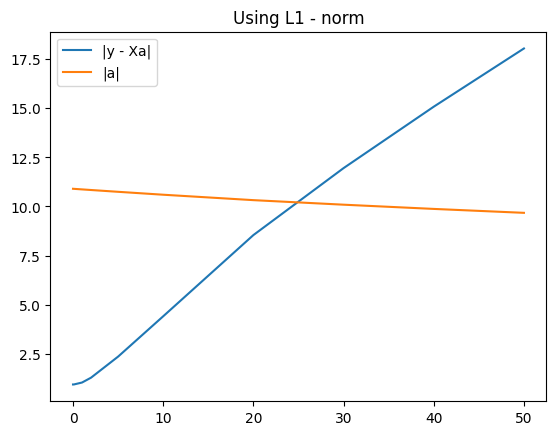

In [112]:
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 40, 50]

solve_for_norm(1, lambdas)

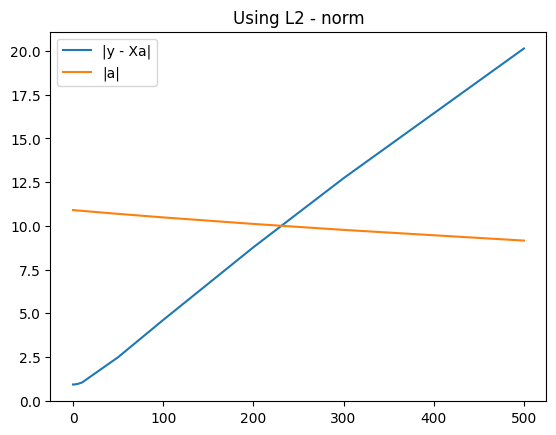

In [113]:
lambdas = [0.01, 0.1, 1, 2, 5, 10, 50, 100, 200, 300, 500]

solve_for_norm(2, lambdas)

In [114]:
def get_solution(l, ord):
  solution, a_value = solve(l, ord)
  err = np.linalg.norm(y - X @ a_value)
  a_norm = np.linalg.norm(a_value)
  return err, a_norm, a_value

# Approx best solution with L1 norm
err, a_norm, a_l1 = get_solution(25, 1)
print(f'L1 norm err ={err}, a_norm = {a_norm}')

# Approx best solution with L2 norm
err, a_norm, a_l2 = get_solution(250, 2)
print(f'L2 norm err ={err}, a_norm = {a_norm}')

L1 norm err =10.373212784858639, a_norm = 10.201875407834526
L2 norm err =10.773595990221454, a_norm = 9.936614812893232


In [115]:
# Find values in a-vector close to zero
eps = 1e-9

l1_zero_idx = [i for i, elem in enumerate(a_l1) if abs(elem) < eps]
l2_zero_idx = [i for i, elem in enumerate(a_l2) if abs(elem) < eps]
print(f'L1 norm opt elements close to zero - idx:{l1_zero_idx}, values: {a_l1[l1_zero_idx]}')
print(f'L2 norm opt elements close to zero - idx:{l2_zero_idx}, values: {a_l2[l2_zero_idx]}')

L1 norm opt elements close to zero - idx:[0, 11, 19, 20, 23, 32, 33, 38, 52, 53, 61, 69, 76, 93], values: [ 9.11601377e-16  4.72636207e-16 -1.77774128e-15  6.18945792e-16
  1.90733375e-15 -4.64316233e-16 -1.88201368e-15  1.38917193e-15
  3.74394167e-15 -6.47498971e-16  3.14409699e-16  3.52230139e-15
  3.84887592e-16 -1.20784474e-15]
L2 norm opt elements close to zero - idx:[], values: []


Using L2-norm in optimization problem does not let get rid of redundant $x_i$ elements.

When using L1-norm in optimization, the following $x_i$ elements are considered redundant: [0, 11, 19, 20, 23, 32, 33, 38, 52, 53, 61, 69, 76, 93]